# Creating and Packaging GeoDataFrame from CSV

## Import Dependencies

In [1]:
import pandas as pd 
import re
from pathlib import Path
import shapely
import geopandas as gpd
from tqdm.notebook import tqdm
tqdm.pandas();

## Define Directory Paths

In [2]:
sample_path = Path('/home/data/sample/L15-0506E-1204N_2027_3374_13')
label_csv_path = Path('/home/data/csvs/sn7_train_ground_truth_pix.csv')
output_path = Path.cwd().parent / 'data'
output_csv_path = output_path/'output_csvs/'
Path(output_csv_path).mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(label_csv_path)

In [4]:
df.head()

,filename,id,geometry
0,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,91,"POLYGON ((814.9857745971531 845.6005742002744,..."
1,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1452,"POLYGON ((886.3093001581728 842.7000443374272,..."
2,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1616,"POLYGON ((930.1175056053326 840.4646877695341,..."
3,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,950,"POLYGON ((923.3884236379527 840.6308379401453,..."
4,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1765,"POLYGON ((926.2129765632562 838.8862611351069,..."


### Extract File Metadata
#### Notes on file names

The function below will use regex to extract the year and month from an input string.

In [5]:
def extract_date(string):
    pattern = r'(\d+)'
    match = re.findall(pattern=pattern,string=string)
    return (match[0],match[1])

The function below will extract the unique file id from the input string.

In [6]:
def extract_file_id(string):
    pattern = r'_(L.+)'
    match = re.findall(pattern=pattern,string=string)
    return match[0]

We then map the extrac_date function on the column containing our filename string in our dataframe, and place them in 2 new columns. One column for the year and one for the month.

In [7]:
df['year'],df['month'] = zip(*df['filename'].progress_map(extract_date))

  0%|          | 0/6664652 [00:00<?, ?it/s]

We do the same for extracting the file_id from the filename string.

In [8]:
df['file_id'] = df['filename'].progress_map(extract_file_id)

  0%|          | 0/6664652 [00:00<?, ?it/s]

In [9]:
df.head()

,filename,id,geometry,year,month,file_id
0,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,91,"POLYGON ((814.9857745971531 845.6005742002744,...",2018,01,L15-0331E-1257N_1327_3160_13
1,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1452,"POLYGON ((886.3093001581728 842.7000443374272,...",2018,01,L15-0331E-1257N_1327_3160_13
2,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1616,"POLYGON ((930.1175056053326 840.4646877695341,...",2018,01,L15-0331E-1257N_1327_3160_13
3,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,950,"POLYGON ((923.3884236379527 840.6308379401453,...",2018,01,L15-0331E-1257N_1327_3160_13
4,global_monthly_2018_01_mosaic_L15-0331E-1257N_...,1765,"POLYGON ((926.2129765632562 838.8862611351069,...",2018,01,L15-0331E-1257N_1327_3160_13


In [10]:
df['year'].value_counts()

2019    3218079
2018    3108106
2020     251332
2017      87135
Name: year, dtype: int64

In [11]:
df['month'].value_counts()

01    768692
04    576131
03    574213
11    568068
02    536911
10    535662
05    532413
09    530252
12    521228
08    520019
06    509831
07    491232
Name: month, dtype: int64

### Convert Well Known Text (WKT) format to shapely polygons

In [12]:
gdf = gpd.GeoDataFrame(df)
gdf['geometry'] = gdf['geometry'].progress_map(shapely.wkt.loads)

  0%|          | 0/6664652 [00:00<?, ?it/s]

In [13]:
print('data type of geometry column before conversion: ', df['geometry'].dtype)
print('data type of geometry column after conversion: ', gdf['geometry'].dtype)

data type of geometry column before conversion:  geometry
data type of geometry column after conversion:  geometry


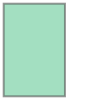

POLYGON ((814.9857745971531 845.6005742002744, 810.2228029975668 845.6005742002744, 810.2228029975668 838.4007334102644, 814.9857745971531 838.4007334102644, 814.9857745971531 845.6005742002744))


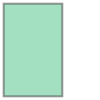

In [14]:
display(df['geometry'][0])
print(gdf['geometry'][0])
display(gdf['geometry'][1])

### Set the Coordinate Reference System (crs) of our GeoDataFrame

In [15]:
gdf.crs = 'EPSG:4326'

In [16]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Saving as GeoDataFrames

In [ ]:
gdf.to_file(output_csv_path/"global_geodataframe.gpkg", driver="GPKG")

We will also extract a subset of our labels, that correspond to the SpaceNet 7 building training sample images.

In [17]:
sample_image_id = 'L15-0506E-1204N_2027_3374_13'

In [18]:
sample_gdf = gdf[gdf['file_id'] == sample_image_id].copy()

In [19]:
sample_gdf['id'].value_counts()

2142    24
1202    24
1162    24
1179    24
1082    24
        ..
2472     2
2474     2
2477     2
2479     1
2478     1
Name: id, Length: 2480, dtype: int64

In [20]:
sample_gdf.to_file(output_csv_path/"sample_geodataframe.gpkg", driver="GPKG")